In [129]:
import pandas as pd
import pickle
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
#reference that helped with this:
#https://stackabuse.com/implementing-lda-in-python-with-scikit-learn/


In [69]:
clean = pd.read_pickle("Cleaned_data.pkl")
del clean['key_name']
del clean['mode_name']
del clean['key_mode']
del clean['type']

In [94]:
wanted  = clean.columns[1:13] #remove track name and labels
#separate into features/labels
features = clean[wanted]
labels = clean['is_hit']
#split data 70-30 training/testing
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state= 420)  
#standardize the data
std = StandardScaler()  
X_train = std.fit_transform(X_train)  
X_test = std.transform(X_test)  

In [41]:
#Run linear SVM 10 times with different C to find out the best one
def runSVM(c):
    svm = LinearSVC(C=c)
    svm.fit(X_train, y_train)
    svm.predict(X_test)
    return(svm.score(X_test, y_test))
svm = LinearSVC()
par = {'C':[1, 2, 5, 10, 20, 50]}
gs = GridSearchCV(svm, par, return_train_score = True)
gs.fit(X_train, y_train)
print(gs.best_params_)
gs.best_score_

{'C': 1}


0.88753991771915186

In [43]:
runSVM(c=1) 

0.88682285023830298

## Linear SVM achieves 88.7% testing accuracy 

In [35]:
#now try with polynomial features 
poly = PolynomialFeatures(degree = 3, include_bias = False)
poly_feat = poly.fit_transform(features)
#resplit into testing and training
X_trainP, X_testP, y_trainP, y_testP = train_test_split(poly_feat, labels, test_size=0.3, random_state= 420)  
#redo LinearSVM
svm = LinearSVC(C=1) #kept C = 2 from LinearSVC above
svm.fit(X_trainP, y_trainP)
poly_preds = svm.predict(X_testP)
svm.score(X_testP, y_testP) #accuracy went down a good amount, so polynomial features aren't efficient

0.83540310129556283

Now we can try SGD since it has different params than linear svm

In [6]:
#use GridSearchCV() to optimize parameters for SGDClassifier
sgd = SGDClassifier(max_iter =  5, tol = None)
par = {'loss':('hinge', 'huber', 'modified_huber', 'log', 'epsilon_insensitive', 'squared_epsilon_insensitive'), 'alpha':[0.0001, 0.001], 'penalty':['l2', 'l1', 'elasticnet']}
gs = GridSearchCV(sgd, par, return_train_score = True)
gs.fit(X_train, y_train)
print(gs.best_params_)
gs.best_score_
#gs.fit()

{'penalty': 'l1', 'loss': 'hinge', 'alpha': 0.0001}


0.88753991771915186

In [47]:
#run SGD with best parameters
sgd_best = SGDClassifier(loss = 'hinge', penalty = 'l1', alpha = 0.0001, max_iter = 10000)
sgd_best.fit(X_train, y_train)
sgdPreds = sgd_best.predict(X_test)
sgd_best.score(X_test, y_test)

0.88682285023830298

## we get basically the same testing accuracy as before, so we can assume 88.7% accuracy is pretty much as accurate as we can get. 

In [50]:
#try seeing auc scores
svm = LinearSVC(C=1)
svm.fit(X_train, y_train)
preds = svm.predict(X_test)
print("Linear svm AUC: ", roc_auc_score(y_test, preds))
print("Polynomial svm AUC: ", roc_auc_score(y_testP, poly_preds)) #polynomial performs slightly better than linear svm
print("SGD svm AUC: ", roc_auc_score(y_test, sgdPreds)) #no improvement for sgd

Linear svm AUC:  0.5
Polynomial svm AUC:  0.512144320044
SGD svm AUC:  0.5


## We can see here that for both Linear SVMs and SGD the AUC is 0.5, which is the same as a constant classifier. Polynomial performs slightly higher with 0.512443, but that is likely an insignificant improvement. 

## Now I will try to do some feature selection and rerun the models to see if AUC will change
## In particular, I'll remove the 'energy', 'mode', 'key', 'instrumentalness', 'explicit', 'liveness', 'valence' and 'acousticness' variables since I suspect they are redundant features (since they are highly correlated with others). Mode and key in particular I think are actually more like categorical variables, so I'll see if  taking them out helps. 

In [66]:
features.corr()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,explicit
danceability,1.000000,-0.030722,-0.017644,0.110433,0.031025,0.017000,-0.237438,-0.110361,-0.167252,0.209298,0.091941,0.145178
energy,-0.030722,1.000000,0.025556,0.705914,-0.021637,-0.053409,-0.410767,-0.121164,0.129310,0.295124,0.096810,0.031145
key,-0.017644,0.025556,1.000000,-0.002041,-0.226802,0.014789,0.033314,0.000125,0.002648,0.063116,-0.009217,-0.011886
loudness,0.110433,0.705914,-0.002041,1.000000,-0.007293,-0.254723,-0.401880,-0.208576,-0.034309,0.129657,0.118785,-0.026936
mode,0.031025,-0.021637,-0.226802,-0.007293,1.000000,0.022706,-0.020437,-0.005078,0.021629,-0.036302,0.004089,0.014558
speechiness,0.017000,-0.053409,0.014789,-0.254723,0.022706,1.000000,0.163634,-0.110668,0.195499,0.176812,-0.011507,0.224991
acousticness,-0.237438,-0.410767,0.033314,-0.401880,-0.020437,0.163634,1.000000,0.100265,0.050411,0.004966,-0.159633,-0.095824
instrumentalness,-0.110361,-0.121164,0.000125,-0.208576,-0.005078,-0.110668,0.100265,1.000000,-0.030919,-0.099386,-0.003108,-0.128906
liveness,-0.167252,0.129310,0.002648,-0.034309,0.021629,0.195499,0.050411,-0.030919,1.000000,0.080366,-0.037132,0.073838
valence,0.209298,0.295124,0.063116,0.129657,-0.036302,0.176812,0.004966,-0.099386,0.080366,1.000000,0.020091,0.016457


In [67]:
#drop seemingly redundant features
new_features = features.drop(['energy', 'mode', 'key', 'instrumentalness', 'explicit', 'liveness', 'valence', 'acousticness'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(new_features, labels, test_size=0.3, random_state= 420)  
#standardize the data
std = StandardScaler()  
X_train = std.fit_transform(X_train)  
X_test = std.transform(X_test) 
#Do LinearSVC again
svm = LinearSVC(C=1)
svm.fit(X_train, y_train)
new_preds_lin = svm.predict(X_test)
print("Linear SVM: ", roc_auc_score(y_test, new_preds_lin)) #auc doesn't change from .5
#polynomial features 
poly_feat = poly.fit_transform(features)
X_trainP, X_testP, y_trainP, y_testP = train_test_split(poly_feat, labels, test_size=0.3, random_state= 420)  
#redo LinearSVM
svm_poly = LinearSVC(C=1) #kept C = 2 from LinearSVC above
svm_poly.fit(X_trainP, y_trainP)
poly_preds_new = svm_poly.predict(X_testP)
print("Polynomial svm AUC: ",roc_auc_score(y_testP, poly_preds_new)) #polynomial performs slightly better than linear svm
sgd_best_new = SGDClassifier(loss = 'hinge', penalty = 'l1', alpha = 0.0001, max_iter = 10000)
sgd_best_new.fit(X_train, y_train)
sgdPreds_new = sgd_best_new.predict(X_test)
print("SGD svm AUC: ", roc_auc_score(y_test, sgdPreds_new)) #no improvement for sgd

Linear SVM:  0.5
Polynomial svm AUC:  0.521181169975
SGD svm AUC:  0.5


## Only polynomial svm's AUC benefited from dropping these variables. At this point, I believe that Support Vector Machine Classifiers are not suited for our problem. 

Some LDA for fun:

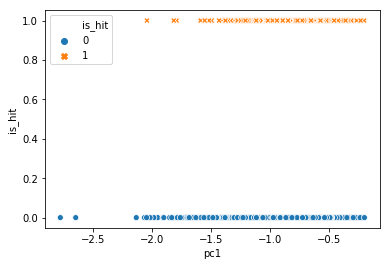

In [143]:
labels = np.array(labels)
lda = LDA(n_components = 3, solver = "eigen")  
x_lda = lda.fit_transform(features, labels)
import seaborn as sns
import matplotlib.pyplot as plt
clean['pc1'] = x_lda[:,0 ]
sns.scatterplot(data=clean[['pc1', 'is_hit']] , x = "pc1", y = "is_hit", hue = "is_hit", style = "is_hit")
plt.show()
#source: https://medium.com/journey-2-artificial-intelligence/lda-linear-discriminant-analysis-using-python-2155cf5b6398?fbclid=IwAR2CadfG6IpRyiRYbatbCyaU0crMMZ6BgjXiTX7V0VC-62rXaneYgWiTvT8